# Bootstrapped Conv NN

A bootstrapped approach to domain adaptation for MNIST to USPS.

Author: @ysbecca

Credits go to:

- [Hvass-Labs](http://www.hvass-labs.org/) for the base CNN model for MNIST classification. Their CNN was deepened and adjusted to iteratively learn the USPS dataset.
- [Leo Pauly](https://github.com/leopauly) for the research in general and the initial code which loads the datasets.

In [1]:
import tensorflow as tf
import numpy as np
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
from datetime import timedelta
from importlib import reload
import math
import time

# Custom scripts.
import ysb
import dataset
import mnist_usps as mnus
import cnn_helper as cn

In [2]:
reload(mnus)
reload(dataset)
reload(cn)

<module 'cnn_helper' from '/Users/ysbecca/ysbecca-projects/Domain-Adaptation/MNIST_USPS_Dataset/cnn_helper.py'>

Set parameters.

In [3]:
# CNN PARAMETERS
filter_size1 = 5          # Convolution filters are 5 x 5 pixels.
num_filters1 = 16         # There are 16 of these filters.

filter_size2 = 5         
num_filters2 = 16    

filter_size3 = 5         
num_filters3 = 32    

fc_size = 128             # Number of neurons in fully-connected layer.

# IMAGE PARAMETERS
img_size = 16             # Width and height in pixels.

# Images are stored in one-dimensional arrays of this length.
img_size_flat = img_size * img_size

# Tuple with height and width of images used to reshape arrays.
img_shape = (img_size, img_size)

# Number of colour channels for the images: 1 channel for gray-scale.
num_channels = 1

# Number of classes, one class for each of 10 digits.
num_classes = 10

## Load both datasets.

In [4]:
mnist_data, usps_data = dataset.read_datasets()

Time elapsed: 0:00:05


In [5]:
print("MNIST dataset:")
print("- Training-set:\t\t{}".format(mnist_data.train.num_images))
print("- Test-set:\t\t{}".format(mnist_data.test.num_images))
print("- Validation-set:\t{}".format(mnist_data.valid.num_images))

print("USPS dataset:")
print("- Training-set:\t\t{}".format(usps_data.train.num_images))
print("- Test-set:\t\t{}".format(usps_data.test.num_images))

MNIST dataset:
- Training-set:		49000
- Test-set:		14000
- Validation-set:	7000
USPS dataset:
- Training-set:		7439
- Test-set:		1859


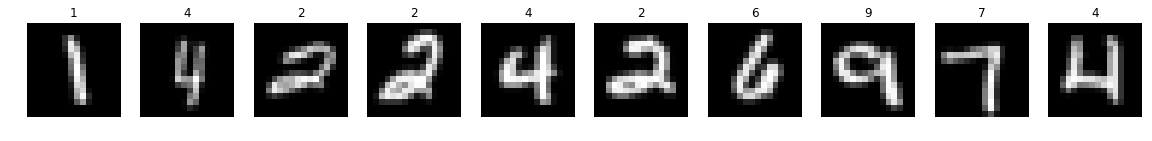

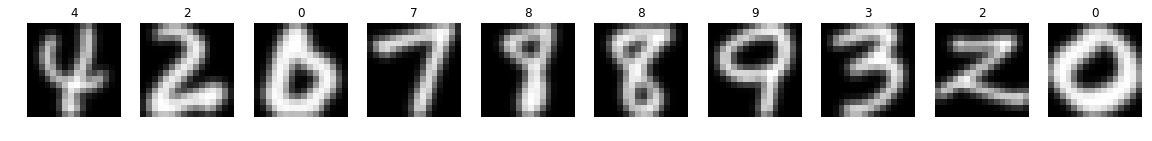

In [6]:
i = 0
ysb.show_labeled_patches_gray(mnist_data.train.images[i:(i+10)], mnist_data.train.cls[i:(i+10)])
ysb.show_labeled_patches_gray(usps_data.train.images[i:(i+10)], usps_data.train.cls[i:(i+10)])

## Train the CNN on MNIST.

First, set up the placeholders.

In [7]:
x = tf.placeholder(tf.float32, shape=[None, img_size_flat], name='x')
x_image = tf.reshape(x, [-1, img_size, img_size, num_channels])
y_true = tf.placeholder(tf.float32, shape=[None, num_classes], name='y_true')
y_true_cls = tf.argmax(y_true, dimension=1) # A placeholder only, so calculated instead of passed directly.

Build TensorFlow graph for a simple 3-layer CNN with max-pooling, ReLU and two fully-connected layers.

In [8]:
layer_conv1, weights_conv1 = \
    cn.new_conv_layer(input=x_image,
                   num_input_channels=num_channels,
                   filter_size=filter_size1,
                   num_filters=num_filters1,
                   use_pooling=True,
                   w_name="conv1_w")
layer_conv2, weights_conv2 = \
    cn.new_conv_layer(input=layer_conv1,
                   num_input_channels=num_filters1,
                   filter_size=filter_size2,
                   num_filters=num_filters2,
                   use_pooling=True,
                   w_name="conv2_w")
layer_conv3, weights_conv3 = \
    cn.new_conv_layer(input=layer_conv2,
                   num_input_channels=num_filters2,
                   filter_size=filter_size3,
                   num_filters=num_filters3,
                   use_pooling=True,
                   w_name="conv3_w")
layer_flat, num_features = cn.flatten_layer(layer_conv3)
layer_fc1 = cn.new_fc_layer(input=layer_flat,                # num_features = 128, from the flattened 3rd layer.
                         num_inputs=num_features,
                         num_outputs=fc_size,
                         use_relu=True,
                         w_name="fc1_w")
layer_fc2 = cn.new_fc_layer(input=layer_fc1,                 # This is the classification layer.
                         num_inputs=fc_size,
                         num_outputs=num_classes,            # num_classes = 10
                         use_relu=False,
                         w_name="fc2_w")
y_pred = tf.nn.softmax(layer_fc2)                            # This is the softmax output prediction.
y_pred_cls = tf.argmax(y_pred, dimension=1)                  # The hard classification, with a threshold of 0.5.

In [9]:
# Cost to be reduced is the the cross entropy over all the images.
cross_entropy = tf.nn.softmax_cross_entropy_with_logits(logits=layer_fc2, labels=y_true)
cost = tf.reduce_mean(cross_entropy)
optimizer = tf.train.AdamOptimizer(learning_rate=1e-4).minimize(cost)

correct_prediction = tf.equal(y_pred_cls, y_true_cls)
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

Now we create a new TensorFlow session and initialise the variables.

In [10]:
session = tf.Session()
session.run(tf.global_variables_initializer())
train_batch_size = 64
test_batch_size = 128

Helper functions for running optimisation iterations and showing test accuracy.

In [11]:
# Counter for total number of iterations performed so far.
total_iterations = 0

def optimize(dataset_train, num_iterations):
    global total_iterations
    start_time = time.time()
    for i in range(total_iterations,
                   total_iterations + num_iterations):
        x_batch, y_true_batch = dataset_train.next_batch(train_batch_size)
        x_batch = x_batch.reshape(len(x_batch), img_size_flat)
        feed_dict_train = {x: x_batch, y_true: y_true_batch}

        session.run(optimizer, feed_dict=feed_dict_train)

        # Print status every 500 iterations.
        if i % 250 == 0:
            # Calculate the accuracy on the training-set.
            acc = session.run(accuracy, feed_dict=feed_dict_train)

            # Message for printing.
            msg = "Optimization Iteration: {0:>6}, Training Accuracy: {1:>6.1%}"
            print(msg.format(i + 1, acc))

    total_iterations += num_iterations

    end_time = time.time()
    time_dif = end_time - start_time
    print("Time usage: " + str(timedelta(seconds=int(round(time_dif)))))
    
def print_test_accuracy(dataset_test, show_confusion_matrix=True):
    num_test = len(dataset_test.images)
    cls_pred = np.zeros(shape=num_test, dtype=np.int)
    i = 0

    while i < num_test:
        # The ending index for the next batch is denoted j.
        j = min(i + test_batch_size, num_test)
        curr_batch_size = j - i
        
        # Get the images and targets from the test-set between index i and j.
        images = dataset_test.images[i:j, :].reshape(curr_batch_size, img_size_flat)
        labels = dataset_test.labels[i:j, :]
        feed_dict = {x: images, y_true: labels}

        cls_pred[i:j] = session.run(y_pred_cls, feed_dict=feed_dict)
        i = j

    # Convenience variable for the true class-numbers of the test-set.
    cls_true = dataset_test.cls

    # Create a boolean array whether each image is correctly classified.
    correct = (cls_true == cls_pred)
    correct_sum = correct.sum()
    acc = float(correct_sum) / num_test

    # Print the accuracy.
    msg = "Accuracy on test set: {0:.1%} ({1} / {2})"
    print(msg.format(acc, correct_sum, num_test))
    
    if show_confusion_matrix:
        print("Confusion matrix:")
        cn.plot_confusion_matrix(cls_true, cls_pred=cls_pred)

Train CNN.

In [12]:
print_test_accuracy(mnist_data.test, show_confusion_matrix=False)

Accuracy on test set: 8.9% (1250 / 14000)


In [13]:
optimize(mnist_data.train, num_iterations=2000)

Optimization Iteration:      1, Training Accuracy:  10.9%
Optimization Iteration:    251, Training Accuracy:  57.8%
Optimization Iteration:    501, Training Accuracy:  70.3%
Optimization Iteration:    751, Training Accuracy:  84.4%
Optimization Iteration:   1001, Training Accuracy:  87.5%
Optimization Iteration:   1251, Training Accuracy:  92.2%
Optimization Iteration:   1501, Training Accuracy:  89.1%
Optimization Iteration:   1751, Training Accuracy:  87.5%
Time usage: 0:01:04


In [14]:
print_test_accuracy(mnist_data.test, show_confusion_matrix=False)

Accuracy on test set: 90.8% (12710 / 14000)


In [15]:
optimize(mnist_data.train, num_iterations=6000)

Optimization Iteration:   2001, Training Accuracy:  93.8%
Optimization Iteration:   2251, Training Accuracy:  89.1%
Optimization Iteration:   2501, Training Accuracy:  96.9%
Optimization Iteration:   2751, Training Accuracy:  98.4%
Optimization Iteration:   3001, Training Accuracy:  96.9%
Optimization Iteration:   3251, Training Accuracy:  95.3%
Optimization Iteration:   3501, Training Accuracy:  96.9%
Optimization Iteration:   3751, Training Accuracy:  95.3%
Optimization Iteration:   4001, Training Accuracy:  98.4%
Optimization Iteration:   4251, Training Accuracy:  98.4%
Optimization Iteration:   4501, Training Accuracy:  93.8%
Optimization Iteration:   4751, Training Accuracy:  90.6%
Optimization Iteration:   5001, Training Accuracy:  96.9%
Optimization Iteration:   5251, Training Accuracy:  93.8%
Optimization Iteration:   5501, Training Accuracy:  98.4%
Optimization Iteration:   5751, Training Accuracy:  98.4%
Optimization Iteration:   6001, Training Accuracy:  98.4%
Optimization I

Accuracy on test set: 95.8% (13413 / 14000)
Confusion matrix:
[[1369    1    3    0    0    2   10    1    6    0]
 [   0 1538    6    2    3    2    7    3    3    0]
 [  10   10 1359    7    4    3    5   14   10    1]
 [   7    8   27 1335    1   26    1   16   24   10]
 [   0    1    2    0 1370    0    7    3    0    4]
 [   3    3    2    3    3 1207   16    1    7    5]
 [   7    4    0    0    7    3 1354    0    1    0]
 [   1    5   11    3   11    1    0 1409    1   10]
 [   5    8    7   10    9    8   13    1 1273    7]
 [  10    3    0    8   88   13    0   34    5 1199]]


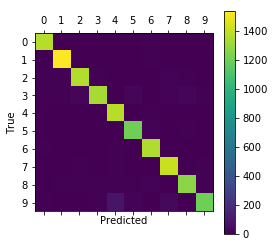

In [16]:
print_test_accuracy(mnist_data.test, show_confusion_matrix=True)

Now test on USPS training set, and display accuracy as well as percentage of results by softmax output.

Accuracy on test set: 63.8% (4744 / 7439)
Confusion matrix:
[[692   0  45  11   1 398   2   0  89   0]
 [  0 295   0   6   1   0   3   0 696   2]
 [  0   1 630  74   4  31   3   0  15   0]
 [  0   1  24 566   0  35   0   1  15   1]
 [  1   1   5   2 477   1  61  27  65  56]
 [  4   0   1  82   1 464   2   0   8   1]
 [  8   2   3   0   0 119 507   0  26   0]
 [  0 132  72  16   3   1   0 355  40   4]
 [  0   0   1  21   0  22   0   0 524   0]
 [  0   0   4  83  65   4   1  48 243 234]]


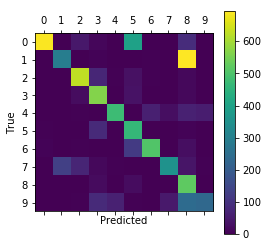

In [17]:
print_test_accuracy(usps_data.train, show_confusion_matrix=True)

In [18]:
def retrieve_predictions(dataset):
    ''' Retrieves the probabilities (not predicted classes) on the given DataSet object. '''
    num_test = len(dataset.images)
    print("Number of images in set: " + str(num_test))

    # Allocate an array for the class probabilities which will be calculated in batches 
    # and added onto this array; this first element is a dummy to maintain shape.
    cls_prob = np.zeros(shape=(1, num_classes), dtype=np.int)
    i = 0

    while i < num_test:
        j = min(i + test_batch_size, num_test)
        curr_batch_size = j - i
        images = dataset.images[i:j, :].reshape(curr_batch_size, img_size_flat)
        labels = dataset.labels[i:j, :]
        feed_dict = {x: images, y_true: labels}

        # Save the softmax output.
        cls_prob = np.concatenate((cls_prob, session.run(y_pred, feed_dict=feed_dict)), axis=0)
        i = j
    
    cls_prob = np.delete(cls_prob, 0, 0) # Remove the first dummy element now.
    return cls_prob

In [19]:
usps_train_preds = retrieve_predictions(usps_data.train)

Number of images in set: 7439


In [20]:
selected = cn.split_by_threshold(0.99, usps_train_preds)

Found 1937 images labeled with confidence >= 0.99


In [21]:
data = dataset.generate_combined_dataset(mnist_data, usps_data)
data.train.add_to_set(selected, usps_data.train, usps_train_preds)
data.usps_train.remove_from_set(selected)

Images added to set: 1937


Optimization Iteration:  11001, Training Accuracy: 100.0%
Optimization Iteration:  11251, Training Accuracy:  96.9%
Optimization Iteration:  11501, Training Accuracy:  93.8%
Optimization Iteration:  11751, Training Accuracy:  96.9%
Time usage: 0:00:27
Accuracy on test set: 65.3% (1214 / 1859)
Confusion matrix:
[[234   0   6   3   0  39   0   0  27   6]
 [  0  57   0   1   0   0   0   0 208   0]
 [  0   0 146  17   0   2   0   0   6   0]
 [  0   0   3 160   0  10   0   0   8   0]
 [  2   0   1   1 106   1   7   1  17  20]
 [  0   0   0  24   0 124   0   0   4   1]
 [  4   0   0   0   0   9 136   0  20   0]
 [  1  53  19   1   1   1   0  65  20   8]
 [  0   0   0   4   0   6   1   0 129   0]
 [  0   0   0   9  13   1   0   7  52  57]]


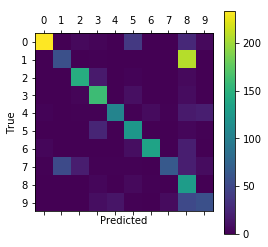

In [30]:
optimize(data.train, num_iterations=1000)
print_test_accuracy(data.test, show_confusion_matrix=True)

Optimization Iteration:  12001, Training Accuracy:  98.4%
Optimization Iteration:  12251, Training Accuracy:  98.4%
Optimization Iteration:  12501, Training Accuracy:  96.9%
Optimization Iteration:  12751, Training Accuracy:  98.4%
Optimization Iteration:  13001, Training Accuracy: 100.0%
Optimization Iteration:  13251, Training Accuracy:  98.4%
Optimization Iteration:  13501, Training Accuracy:  98.4%
Optimization Iteration:  13751, Training Accuracy:  96.9%
Optimization Iteration:  14001, Training Accuracy:  96.9%
Optimization Iteration:  14251, Training Accuracy:  98.4%
Optimization Iteration:  14501, Training Accuracy:  96.9%
Optimization Iteration:  14751, Training Accuracy:  98.4%
Time usage: 0:01:19
Accuracy on test set: 59.2% (1101 / 1859)
Confusion matrix:
[[205   0  16   4   0  48   0   0  37   5]
 [  0  37   0   2   0   0   0   0 227   0]
 [  0   0 149  15   0   2   0   0   5   0]
 [  0   0   3 167   0   6   0   0   5   0]
 [  1   3   3   0  97   2  11   2  26  11]
 [  0   0

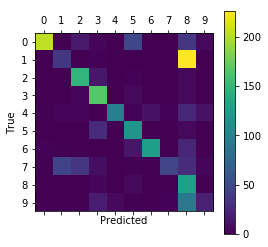

In [31]:
optimize(data.train, num_iterations=3000) # Too much training - overfitting MNIST decreases performance on USPS.
print_test_accuracy(data.test, show_confusion_matrix=True)

Now re-run the remaining USPS train set through the CNN and bootstrap the top 0.99 again.

In [32]:
# Plot accuracy over bootstrap iterations. 

## Close TensorFlow session

Releases all resources! Run only when prepared to lose saved CNN model.

In [33]:
session.close()